In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import hyperopt as hpt
from preprocessing.country_and_airports_codes import compute_lon_lat,group_and_rename_countries, group_and_rename_airports, group_and_rename_aircraft_types
from preprocessing.encoding import one_hot_encoding,string_to_value_count, string_to_int_hashing
from preprocessing.local_time import add_localtime_to_train_and_test

In [ ]:
train_df = pd.read_csv("./data/preprocessed_challenge_set.csv", index_col=0)
test_df = pd.read_csv("./data/preprocessed_submission_set.csv", index_col=0)

# encoding

columns_to_ohe = [] # A changer
one_hot_encoding(train_df, test_df, columns_to_ohe)

columns_to_hash = ['callsign','country_code_ades', 'country_code_adep', 'adep', 'ades', 'airline','aircraft_type','wtc'] # A changer
string_to_int_hashing(train_df, test_df, columns_to_hash)

columns_to_vc = [] # A changer
string_to_value_count(train_df, test_df, columns_to_vc)

# drop unusefull column:
to_drop = ['flight_id','date','name_adep','name_ades','name_adep','actual_offblock_time','arrival_time','local_departure_time','local_arrival_time']
train_df = train_df.drop(columns= to_drop)
test_df = test_df.drop(columns= to_drop)



In [59]:
# Split the data

X = train_df.drop(columns=['tow'])
y = train_df['tow']

display(X)
display(y)

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)


print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)


print(y_test)

display(X_train)

,callsign,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,local_arrival_hour,local_departure_hour,travel_day_of_week,travel_day_of_year,departure_month,lon_adep,lat_adep,lon_ades,lat_ades
0,2356,19,11,28,18,3,1,20,61,18,321,15,13,5,1,1,-0.46194,51.47060,-8.49111,51.84130
1,10522,58,8,62,52,10,0,10,570,13,4193,14,10,5,1,1,2.07846,41.29710,-80.29012,25.79536
2,830,41,34,64,52,6,0,18,554,15,3770,13,10,5,1,1,17.91860,59.65190,-87.90815,41.97694
3,3379,89,3,65,52,13,0,10,497,11,3607,14,12,5,1,1,8.54917,47.46470,-75.24066,39.87208
4,8863,25,15,22,13,1,1,20,55,14,305,13,12,5,1,1,-6.27007,53.42130,-0.46194,51.47060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369008,5605,67,10,62,52,13,0,10,545,21,4046,14,10,5,365,12,2.55000,49.01280,-80.29012,25.79536
369009,3642,93,45,4,8,1,1,14,158,25,946,13,12,5,365,12,28.75200,41.27533,13.50067,52.36217
369010,3803,7,6,29,18,3,1,20,99,11,522,11,10,5,365,12,6.76678,51.28950,-6.27007,53.42130
369011,6817,67,10,29,18,1,1,20,84,12,466,11,10,5,365,12,2.55000,49.01280,-6.27007,53.42130


0          54748.000000
1         185441.000000
2         230396.000000
3         157615.000000
4          70318.447226
              ...      
369008    163438.000000
369009     78707.000000
369010     62942.750000
369011     72611.161024
369012    195373.000000
Name: tow, Length: 369013, dtype: float64

Train shape:  (295210, 20)
Test shape:  (73803, 20)
352433    63744.000000
194975    67765.000000
183246    69560.909091
324008    65844.000000
88820     81781.000000
              ...     
254878    63817.085363
202762    33865.000000
79058     74682.000000
163177    58244.217218
60406     61783.000000
Name: tow, Length: 73803, dtype: float64


,callsign,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,local_arrival_hour,local_departure_hour,travel_day_of_week,travel_day_of_year,departure_month,lon_adep,lat_adep,lon_ades,lat_ades
100101,9101,41,34,46,39,0,1,18,51,15,301,9,7,4,126,5,17.91860,59.65190,13.37620,55.53631
97559,6902,77,17,57,52,10,0,10,674,18,4964,14,10,2,124,5,12.25080,41.80450,-97.03769,32.89723
37728,1245,16,11,147,32,9,1,6,143,17,932,9,6,6,58,2,-2.27495,53.35370,-22.60560,63.98500
300144,4766,28,7,9,8,3,1,18,73,10,470,15,14,6,296,10,12.65600,55.61790,11.78610,48.35380
121031,7738,3,6,2,2,3,1,22,64,8,354,8,6,1,144,5,13.50067,52.36217,4.48444,50.90140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282558,7396,64,10,29,18,3,1,20,105,10,679,17,17,5,281,10,5.09083,45.72640,-6.27007,53.42130
322428,10554,25,15,75,10,3,1,20,146,26,874,11,7,4,315,11,-6.27007,53.42130,-3.56676,40.49360
75062,7001,57,8,120,13,9,1,6,137,12,1026,14,13,1,102,4,-0.55816,38.28220,-1.01066,53.48054
130949,5565,92,45,121,33,9,1,14,141,15,982,4,0,4,154,6,29.30920,40.89860,50.04670,40.46750


In [60]:
# Train data

train_data =  lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [ ]:
params = { 
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'goss',
    'num_leaves': 31, 
    'learning_rate':0.12389641912229452, 
    'feature_fraction': 0.9, 
} 

num_round = 2000

bst = lgb.train(params, train_data, num_round, valid_sets=[ 
                test_data], callbacks=[lgb.early_stopping(stopping_rounds=20)])

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

print("RMSE: ", root_mean_squared_error(y_test, y_pred))


In [ ]:
#plot y_pred vs y_test

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)

plt.show()

In [ ]:
# Same thing, but only train where wtc = 0

X_train_wtc_0 = X_train[X_train['wtc'] == 0]

y_train_wtc_0 = y_train[X_train['wtc'] == 0]

X_test_wtc_0 = X_test[X_test['wtc'] == 0]

y_test_wtc_0 = y_test[X_test['wtc'] == 0]

train_data_wtc_0 =  lgb.Dataset(X_train_wtc_0, label=y_train_wtc_0)

test_data_wtc_0 = lgb.Dataset(X_test_wtc_0, label=y_test_wtc_0, reference=train_data_wtc_0)

bst_wtc_0 = lgb.train(params, train_data_wtc_0, num_round, valid_sets=[
                test_data_wtc_0], callbacks=[lgb.early_stopping(stopping_rounds=20)])

y_pred_wtc_0 = bst_wtc_0.predict(X_test_wtc_0, num_iteration=bst_wtc_0.best_iteration)

print("RMSE: ", root_mean_squared_error(y_test_wtc_0, y_pred_wtc_0))



In [ ]:
# same thing, but only train where wtc = 1

X_train_wtc_1 = X_train[X_train['wtc'] == 1]

y_train_wtc_1 = y_train[X_train['wtc'] == 1]

X_test_wtc_1 = X_test[X_test['wtc'] == 1]

y_test_wtc_1 = y_test[X_test['wtc'] == 1]

train_data_wtc_1 =  lgb.Dataset(X_train_wtc_1, label=y_train_wtc_1)

test_data_wtc_1 = lgb.Dataset(X_test_wtc_1, label=y_test_wtc_1, reference=train_data_wtc_1)

bst_wtc_1 = lgb.train(params, train_data_wtc_1, num_round, valid_sets=[
                test_data_wtc_1], callbacks=[lgb.early_stopping(stopping_rounds=20)])

y_pred_wtc_1 = bst_wtc_1.predict(X_test_wtc_1, num_iteration=bst_wtc_1.best_iteration)

print("RMSE: ", root_mean_squared_error(y_test_wtc_1, y_pred_wtc_1))

In [56]:
# hyperopt on the parameters
import warnings
warnings.filterwarnings("ignore")
space = {
        #this is just piling on most of the possible parameter values for LGBM
        #some of them apparently don't make sense together, but works for now.. :)
        'objective': 'regression',
        'metric': 'rmse',
        'num_threads': 4,
        'num_boost_round': 2000,
        'class_weight': hpt.hp.choice('class_weight', [None, 'balanced']),
        'boosting_type':hpt.hp.choice('boosting_type', ['gbdt',  'goss']),
        'num_leaves':hpt.hp.quniform('num_leaves', 30, 150, 1),
        'learning_rate':hpt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'feature_fraction':hpt.hp.uniform('feature_fraction', 0.5, 1),
        'bagging_fraction':hpt.hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'lambda_l1':hpt.hp.choice('lambda_l1', [0,hpt.hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2':hpt.hp.choice('lambda_l2', [0,hpt.hp.loguniform('lambda_l2_positive', -16, 2)]),
        'verbose': -1,
        'max_depth':hpt.hp.quniform('max_depth', 3, 20, 1),
        #the LGBM parameters docs list various aliases, and the LGBM implementation seems to complain about
        #the following not being used due to other params, so trying to silence the complaints by setting to None
#        'subsample': None, #overridden by bagging_fraction
#        'reg_alpha': None, #overridden by lambda_l1
#        'reg_lambda': None, #overridden by lambda_l2
#        'min_sum_hessian_in_leaf': None, #overrides min_child_weight
#        'min_child_samples': None, #overridden by min_data_in_leaf
#        'colsample_bytree': None, #overridden by feature_fraction
#        'min_child_samples':hpt.hp.quniform('min_child_samples', 20, 500, 5),
        'min_child_weight':hpt.hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
#        'reg_alpha':hpt.hp.uniform('reg_alpha', 0.0, 1.0),
#        'reg_lambda':hpt.hp.uniform('reg_lambda', 0.0, 1.0),
#        'colsample_bytree':hpt.hp.uniform('colsample_by_tree', 0.6, 1.0),
    }

quniform_params = ['num_leaves', 'min_child_samples', 'subsample_freq', 
                   'max_bin', 'max_cat_threshold', 
                   'max_cat_to_onehot', 'top_k',
                   'max_depth', 'bagging_freq','max_drop','min_data_in_leaf'
                   ,'subsample_for_bin','hist_nbins','max_position','min_data_in_bin','max_depth']

def objective(params):

    # put each quniform list in the space set to int

    for key in params.keys():
        if key in quniform_params:
            params[key] = int(params[key])




    bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=30)])


    score = bst.best_score['valid_0']['rmse']
    return score

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100)

print(best)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:        
[2000]	valid_0's rmse: 3817.21
Training until validation scores don't improve for 30 rounds                     
Early stopping, best iteration is:                                               
[1261]	valid_0's rmse: 3630.36
Training until validation scores don't improve for 30 rounds                     
Did not meet early stopping. Best iteration is:                                 
[2000]	valid_0's rmse: 3627.27
Training until validation scores don't improve for 30 rounds                    
Did not meet early stopping. Best iteration is:                                 
[2000]	valid_0's rmse: 3668.03
Training until validation scores don't improve for 30 rounds                    
Did not meet early stopping. Best iteration is:                                 
[1999]	valid_0's rmse: 3670.56
Training until validation scores don't improve for 30 rounds                 

In [ ]:
print("Best parameters: ", best)

In [67]:
params = {'bagging_fraction': np.float64(0.8857573128938919), 
          'boosting_type': 'gbdt', 'class_weight': 'balanced', 
          'feature_fraction': np.float64(0.868157453580226), 
          'lambda_l1': np.int64(1), 
          'lambda_l1_positive': np.float64(8.544756287729055e-05), 
          'lambda_l2': np.int64(1), 'lambda_l2_positive': np.float64(9.555302226613002e-05), 
          'learning_rate': np.float64(0.04229598224890242), 'max_depth': 19, 
          'min_child_weight': np.float64(0.3585748721867265), 'num_leaves': 137,
          'num_boost_round': 2000, 'objective': 'regression', 'metric': 'rmse', 'num_threads': 4, 'verbose': -1}

bst = lgb.train(params, train_data, num_round, valid_sets=[
                test_data], callbacks=[lgb.early_stopping(stopping_rounds=20)])

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

print("RMSE: ", root_mean_squared_error(y_test, y_pred))

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3185.46
RMSE:  3185.4586292071717


params=  {'bagging_fraction': np.float64(0.8192370146422706), 
          'boosting_type': 'gbdt', 
          'class_weight': None, 
          'feature_fraction': np.float64(0.8548089937102925), 
          'lambda_l1': 0, 
          'lambda_l2': 0, 
          'learning_rate': np.float64(0.03627857032433739), 
          'min_child_weight': np.float64(1.250687378700556e-07), 
          'num_leaves': 147,
          'objective': 'regression',
          'metric': 'rmse',
          'num_threads': 4,
          'num_boost_round': 2000,
          'verbose': -1
          }

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

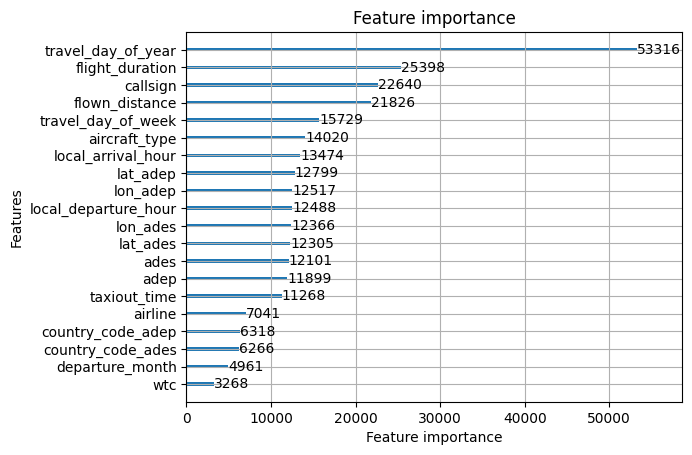

In [52]:
# plot feature importance

lgb.plot_importance(bst)